# Sarcasm Detection in headlines


Project title: Sarcasm detection in newspaper headlines 

Data: https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection

**Pre processing:**
First we removed punctuations and stemmed all words. Hereafter we embedded our word vectors using word2vec with pretrained word vectors (GloVe, 100 dimensions) and removed headlines with less than 3 words

**Modelling:**
We have implemented a hidden markov model (HMM) and a probabilistic recurrent neural network (RNN) in order to classify the headlines. These models did however perform very poorly, so we also tried adressing the problem using a non-probabilistic models - a standard LSTM model.
Furthermore, we also tried looking at the high dimensional input data as a cause of poor performance, and implemented a logistic regression model, which only used four input values, based on calculations of the cosine similarity between embedded words in a headline. The exact calculation used to determine whether a sentence is sarcastic or not, is described in the orignial paper:
https://www.aclweb.org/anthology/D16-1104.pdf

**HMM**
We built a HMM with two hidden states (non-sarcastic = 0, sarcastic = 1) and trained it on our embedded data.
As prior distributions for the individual words we assumed a 100 dimensional multivariate distribution with mean 0. In order to calculate the posterior distribution, we used the conjugate prior for the multivariate distribution. Here we used a gaussian for the mean and the LKJCorrCholesky distribution to model the covariance matrix. 
Detection of sarcasm on a test sample is done by computing the average of the latent states, and determining whether this is above or below a cutoff point of 0.5. This is a biased cutoff point, as illustrated by an example headline of 6 words, where our model predicts "non-sarcastic" for 3 words and "sarcastic" for the other 3. In this case, the prediction for the overall headline would be "non-sarcastic"

**RNN**
We implemented a probabilistic RNN model with inspiration from material from week 5 in the course and tested it on simulated data to evaluate whether our implementation was correct. This model performed satisfactory and we therefore also tried training the model to classify headlines from our sarcasm dataset, however these predictions were as good as random.
Our implementation of the standard LSTM seemed more promising and was able to learn. It had a classification accuracy of 0.679, however this was on the training set, and is most likely therefore also part overfitting.

In [0]:
# IMPORTS
!pip install pyro-ppl

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import os

import torch
from torch import nn
from torch.distributions import constraints
import functools

from pyro.infer import SVI, JitTraceEnum_ELBO, Trace_ELBO
import pickle 

from sklearn.model_selection import train_test_split

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList, AutoDelta
from pyro.optim import ClippedAdam
from pyro import poutine
from pyro.infer import Predictive

from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO, TraceTMC_ELBO
from pyro.ops.indexing import Vindex
from pyro.optim import Adam
from pyro.util import ignore_jit_warnings
from pyro.params.param_store import ParamStoreDict

     |████████████████████████████████| 522kB 2.7MB/s 


#INTRODUCTION

In this project, we will use a model-based machine learning approach to model headlines. Our dataset consist of two types of headlines; sarcastic and non-sarcastic. Our ultimate goal, is to create a classifier that is able to predict if a headline is sarcastic or not.

Since our data is text-data, we are going to enter the field of Natural-Language-Processing which is a combination of Computer Science, Data Science and Linguistics. When combining computers and text-data, the text has to be processed into numerical representation, as computers essentially only understand numbers. This complicates the process of working with the data a lot and makes the pre-processing non-trivial. 

In this project, we have decided to use a text-embedding called GloVe (Global Vector Representation). GloVe is a unsupervised machine learning model, that has been trained on millions of sentences, to learn how to map every word found on Wikipedia to a 100-dimensional vector representation. This vector representation is a semantic representation of every word, meaning that the interpretation is encoded within the 100-dimensional vector.

The training sessions illustrated in this notebook only shows simple examples. THe more complicated ones with a higher amount of epochs, weren't all done in one session of the notebook, and couldnt therefore all be shown together.

# PRE PROCESSING

In [0]:
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
import string
nltk.download('punkt')
nltk.download('stopwords')

import os
import json
import numpy as np

%matplotlib notebook

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from google.colab import drive
#drive.mount('/content/drive')

In [0]:

#os.chdir('drive/My Drive/School/Master/Model Based Machine Learning/MBML Project/sarcasm')
#os.chdir('drive/My Drive/MBML Project/sarcasm')
#os.chdir('drive/My Drive/DTU_Kurser/Model_Based_ML/sarcasm')
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1MJ9_gcXivLwH8_OuPdmc9qIGBxLsXB8M/sarcasm'

In [0]:
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [0]:
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

In [0]:
data = list(parse_data('./Sarcasm_Headlines_Dataset.json/Sarcasm_Headlines_Dataset.json'))

Create a dataframe of our dataset. Each row in the dataframe contains the sentence and the label (1=sarcastic, 0=non sarcastic)

In [0]:
df_headlines = pd.DataFrame(columns=['headline', 'label'])
for article in data:
    df_tmp = pd.DataFrame([[article['headline'], article['is_sarcastic']]], columns=['headline', 'label'])
    df_headlines = df_headlines.append(df_tmp)

Function for processing our data. This functions has the following steps:

1. Remove punctuation
2. Tokenize every word
3. Remove stopwords
4. Lowercase every word
5. Remove sentence, if there are less than three words

In [0]:
def process_text_list(x):
    # Remove punctuation
    table = str.maketrans(dict.fromkeys(string.punctuation) )
    x = x.translate(table)

    # Tokenize words (returns list)
    x = TreebankWordTokenizer().tokenize(x)

    # Remove stop words
    x = [word.lower() for word in x if not word in stop_words]

    #If sentence has less than 3 words, this functions returns None.
    if len(x) > 3:
      return x
      

In [0]:
#Apply processing function
df_headlines['headline_processed'] = df_headlines['headline'].apply(process_text_list)

#Remove observations, where the processing returns None (headlines with less than three words).
df_headlines = df_headlines.dropna()

#Fix the indexing on dataframe
df_headlines.index = list(range(len(df_headlines)))

df_headlines.head()

,headline,label,headline_processed
0,former versace store clerk sues over secret 'b...,0,"[former, versace, store, clerk, sues, secret, ..."
1,the 'roseanne' revival catches up to our thorn...,0,"[roseanne, revival, catches, thorny, political..."
2,mom starting to fear son's web series closest ...,1,"[mom, starting, fear, sons, web, series, close..."
3,"boehner just wants wife to listen, not come up...",1,"[boehner, wants, wife, listen, come, alternati..."
4,j.k. rowling wishes snape happy birthday in th...,0,"[jk, rowling, wishes, snape, happy, birthday, ..."


## Word embedding

Word embedding is a method of representing a word as an nth dimensional vector. This method is widely used in natural language processing as it converts words into computational form. 

In [0]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(400000, 100)

In [0]:
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Apply the word embedding to the words in our headlines and store them in "final_list", while the sarcastic label for each headline is stored in the "labels".

It became apparent that many of the words used in our headlines were not defined by our embeddings, leading to a considerable amount of words being discarded from out data. This could have a negative impact on the prediction power of our model, since potentially important parts of the data would not be considered.

In [0]:
# final_list contain our embedded headlines which are imputs to our models (observations)
final_list = []
count = 0
except_list = []

for idx, sentence in enumerate(list(df_headlines['headline_processed'])):
    sentence_list = []
    
    # This statement removes words that do not contain an embedding in the GloVe library
    for word in sentence:
        try:
            sentence_list.append(model.word_vec(word))
        except:
            count += 1
            except_list.append([word, idx])
    final_list.append(sentence_list)

# Creats list with a sarcasm label for each headline
labels = list(df_headlines['label'])

In [0]:
# Find the number of words that produced an error due to not being present in the GloVe library,
# and determine if it came from a sarcastic headline or not. 
sarcasm_count = 0
non_sarcasm_count = 0
for word in except_list:
    if df_headlines['label'][word[1]] == 1:
        sarcasm_count += 1
    else:
        non_sarcasm_count += 1

In [0]:
print(f'Number of unidentified words in sarcastic headlines: {sarcasm_count}')
print(f'Number of unidentified words in non sarcastic headlines: {non_sarcasm_count}')
print(f'Total number of unidentified words in corpus {sarcasm_count + non_sarcasm_count}')

Number of unidentified words in sarcastic headlines: 2512
Number of unidentified words in non sarcastic headlines: 2581
Total number of unidentified words in corpus 5093


In [0]:
print(f'Fraction of headlines being sarcastic in corpus : {df_headlines["label"].sum()/len(df_headlines)}')

Fraction of headlines being sarcastic in corpus : 0.4497153700189753


Before we begin our modelling we want to see how the GloVe model actually represents words. By counting where every vector-dimension for every word is located, we can get some usual information about our priors when modelling the problem. 

We see in the histogram plot below that every dimension looks to be normally distributed around 0 with variance 1. This prior will be used in our modelling.

In [0]:
from collections import defaultdict
obs_dict = defaultdict(list)

for headline in final_list:
    for word in headline:
        for idx, embedding in enumerate(word):
            obs_dict[idx].append(embedding)

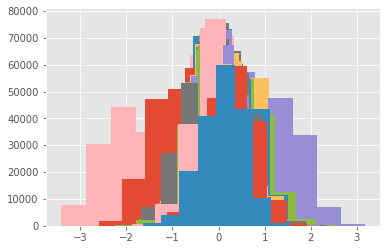

In [0]:
%matplotlib inline
for i in range(100):
    plt.hist(sorted(obs_dict[i]))

In [0]:
# Make fial_list and labels list of tensors so that it can be run with pyro
final_list = [torch.tensor(i) for i in final_list]
labels = [torch.tensor(i) for i in labels]

pickle.dump( labels, open( "labels.pickle", "wb" ) )
pickle.dump( final_list, open("embedded_data.pickle", "wb"))
pickle.dump(model, open("GloVe_model.pickle", "wb"))

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


#Load pickle and split into test/train set

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#os.chdir('drive/My Drive/School/Master/Model Based Machine Learning/MBML Project/sarcasm')
os.chdir('drive/My Drive/MBML Project/sarcasm')
#os.chdir('drive/My Drive/DTU_Kurser/Model_Based_ML/sarcasm')


In [0]:
# LOAD DATA AND MODEL
final_list = pickle.load(open('embedded_data.pickle','rb'))
labels = pickle.load(open('labels.pickle', 'rb'))
model = pickle.load(open('GloVe_model.pickle', 'rb'))

X_train, X_test, y_train, y_test = train_test_split(final_list, labels, test_size=0.3)

# Hidden Markov Model:

Our first model will be a Hidden Markov Model(HMM). This model is used for sequences of data, where the goal is to model a "hidden representaion" also called a latent state using an observed sequence. In our case the latent state will be the label for each sequence of data and the observed values will be every word embedded using GloVe. This also makes this model sub-optimal for our problem, as the HMM is used for sequences of data, where the latent representation changes throughout the sequence.

Instead, in our case, the latent state throughout the sequence/headline will stay static, i.e. a headline will always be sarcastic or non-sarcastic. However, as this model is a good option to show our learnings throughout this course, we decided to stick with it, even though it is not a model that directly is used for classification.

In [0]:
def hmm_model(data=None, labels=None, include_prior=True):
    """
    Create HMM with an argument for the data and a argument for the label
    Both can be set to None and the model would in this case be generative
    """
    if data is None:
        num_headlines = 1
    else:
        num_headlines = len(data)
    embedding_size = 100

    with poutine.mask(mask=include_prior):
        # Transition from a state to another
        probs_x = pyro.sample("probs_x",
                            dist.Dirichlet(0.5 * torch.eye(2) + 0.5).to_event(1))
        
        # Sample from covariance prior
        theta_probs = pyro.sample("theta_probs", dist.HalfCauchy(torch.ones(embedding_size).expand([2, embedding_size]))
                                    .to_event(2))
        eta = 10*torch.ones(1)
        L_omega_probs = pyro.sample("probs_L_omega", dist.LKJCorrCholesky(embedding_size, eta).expand([2]).to_event(1))
        
        cov_probs = torch.bmm(theta_probs.sqrt().diag_embed(), L_omega_probs)
        
        # Sample from mean prior
        mean_probs = pyro.sample('probs_mean', 
                                dist.MultivariateNormal(torch.zeros(2, embedding_size),
                                                        torch.eye(embedding_size)).to_event(1))
    # Iterate through headlines
    for i in pyro.plate("headlines", num_headlines):

        # If model is used for freestyling instead of training then we assume that the number of words in the sentence is 10
        if data is None:
            headline = None
            num_words = 10
        else:
            headline = data[i]
            num_words = len(data[i])

        # Assume random state of first word (sarcastic/non-sarcastic)
        x_obs = torch.randint(low=0, high=2, size=(1,))[0]
        

        for t in pyro.markov(range(num_words)):

            # If model used for prediction then current_label and current_headline is set to None
            try:
                current_label = labels[i]
                current_headline = headline[t]
            except:
                current_label = None
                current_headline = None
                
            # Here we sample the latent variable based on the current label
            x_obs = pyro.sample("x_{}_{}".format(i, t), dist.Categorical(probs_x[x_obs]),
                            infer={"enumerate": "parallel"}, obs=current_label)

            # Here we sample the embedded
            y = pyro.sample(f"y_{i}_{t}", dist.MultivariateNormal(mean_probs[x_obs, :], scale_tril=cov_probs[x_obs, :, :] ),
                            obs = current_headline)

##TRAIN MODEL ON TRAIN SET

In [0]:
# Use AutoDelta guide
guide = AutoDelta(hmm_model)
optim = Adam({'lr': 0.1})
elbo = TraceEnum_ELBO(max_plate_nesting=3)
svi = SVI(hmm_model, guide, optim, elbo)

epochs = 15
elbo_list = list()

# Training loop
for step in range(epochs):
    elbo = svi.step(X_train, y_train)
    elbo_list.append(elbo)
    print(f'{step+1}: {elbo}')


1: 17325410.0
2: 12827687.0
3: 11603538.0
4: 11706135.0
5: 11830917.0
6: 11784903.0
7: 11352413.0
8: 10763279.0
9: 10270653.0
10: 9912960.0
11: 9682098.0
12: 9559129.0
13: 9511603.0
14: 9492961.0
15: 9475171.0


Text(0, 0.5, 'ELBO')

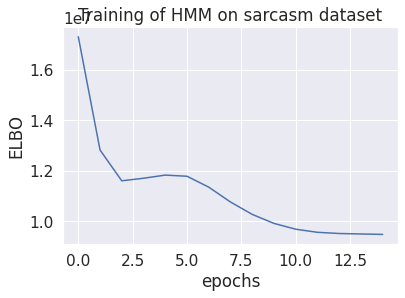

In [0]:
plt.plot(elbo_list)
plt.title('Training of HMM on sarcasm dataset')
plt.xlabel('epochs')
plt.ylabel('ELBO')

##Evaluate on test set

**The Generative process**

In order to evaluate our model, we first test its freestyling ability by generating a sentence after having been trained. 

In [0]:
predictive = Predictive(hmm_model, guide=guide, num_samples=1, return_sites = {'probs_x'})
informativ_sentence = predictive()

The transition matrix given below shows why our assumptions for using a HMM for binary classification are flawed. It is clear that the diagonal elements, i.e. staying in the same state are close to 1. This is what we have taught the model when the observed states were the same throughout the headline. This is also why randomly picking a state for the first word will make the model inclined towards staying within that state.

In [0]:
predictive()

{'probs_x': tensor([[[0.9453, 0.0547],
          [0.0756, 0.9244]]], grad_fn=<ViewBackward>)}

In [0]:
# This converts the sampled embedding to the actual words, by locating the most 
# similar embedding in the GloVe library
for i in range(10):
    vec = np.array(informativ_sentence[f'y_0_{i}'][0].detach().numpy())
    word = model.similar_by_vector(vec, topn=1)[0][0]

    # This prints the word sampled in the freestyling run, as well as if they have been sampled 
    # based on a sarcastic distribution or not
    print(word, '\t', informativ_sentence[f'x_0_{i}'])

http://www.nrlc.org 	 tensor([0])
mist 	 tensor([0])
refusal 	 tensor([0])
safireonlanguage@nytimes.com 	 tensor([0])
manning 	 tensor([0])
people 	 tensor([0])
representatives 	 tensor([0])
circulars 	 tensor([0])
impulses 	 tensor([0])
addressed 	 tensor([0])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


This is a simple evaluation method where the sarcastic label of the headline is based on the mean of its latent variable. Meaning, that if the mean is about 0.5 the senctence is assigned to be sarcastic and if it is under 0.5 then it is assigned to be non-sarcastic.

This method is not optimal since the first words in each headline has a random assignment, but still contribute just as much to the label determination as the words towards the end of the headline, where the model has a better idea of the headlines character. 

We attempted to fix this by putting a logistic regression classifier on the latent variabl. We could however not manage to get this to work in pyro, and at that time also realized that a HMM model was not optimal for this type of problem (classification). We therefore decided to spend our time on building a recurrent neural network (RNN) instead of continue to optimizing the HMM.

In [0]:
def eval_hmm(X, y):
    #Count
    tp = 0 #true possitive
    fp = 0 #false possitive
    tn = 0 #true negative
    fn = 0 #false negative

    for idx in range(len(X)):
        sum_states = 0

        sentence = predictive.forward(X[idx:idx+1], None)
        num_words = len(X[idx:idx+1][0])

        # number of words
        for i in range(num_words):
            sum_states += sentence[f"x_0_{i}"][0]

        # Aggregate prediction - this creates a small bias towards non-sarcastic
        if sum_states/num_words > 0.5:
            pred = 1
        else:
            pred = 0

        # Compute confusion matrix
        if pred == 1 and y[idx].item() == 1:
            tp += 1
        elif pred == 0 and y[idx].item() == 1:
            fn += 1
        elif pred == 1 and y[idx].item() == 0:
            fp += 1
        elif pred == 0 and y[idx].item() == 0:
            tn +=1
        else:
          print("Something went wrong. Check format of input")
          break

    return tp, fn, fp, tn

In [0]:
test_x = X_test
test_y = y_test

tp, fn, fp, tn = eval_hmm(test_x, test_y)

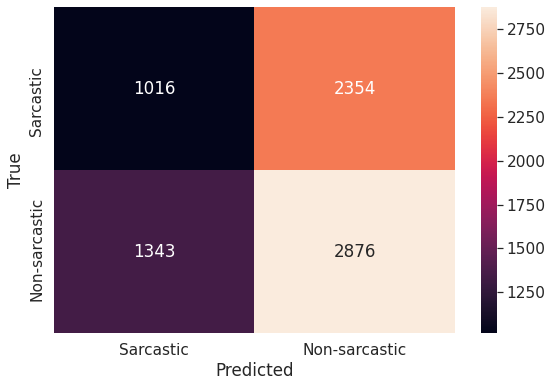

In [0]:
import seaborn as sn

arr = np.array([[tp, fn], 
                [fp, tn]])

df_cm = pd.DataFrame(arr, index=['Sarcastic', 'Non-sarcastic'], columns=['Sarcastic', 'Non-sarcastic'])
df_cm.index.name = "True"
df_cm.columns.name = "Predicted"

sn.set(font_scale=1.4) # for label size

f, ax = plt.subplots(figsize=(9, 6))
sn.heatmap(df_cm, annot=True, linewidths=0, fmt='d', ax = ax) # font size
ax.set_yticks([0.4,1.2])

plt.show()

The confusion matrix confirms that there is a bias towards predicting a sentence to be non-sarcastic

#Data Preprocessing for ANN

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [0]:
# LOAD DATA AND EMgMODEL
final_list = pickle.load(open('embedded_data.pickle','rb'))
labels = pickle.load(open('labels.pickle', 'rb'))
model = pickle.load(open('GloVe_model.pickle', 'rb'))


In [0]:
#Padds the headlines with tensors so all headlines are of equal length
padded_headlines = nn.utils.rnn.pad_sequence(final_list[0:len(final_list)])
padded_headlines = padded_headlines.view(len(final_list), 25, 100)

# Bayesian ANN WITH SIMULATED DATA

Bayesian Artificial Neural Network: Proof of concept using simulated data.

Because we would like to implement a bayesian-ANN on our data, we first tried to fit it to some simulated data to test if we were able to implement it correctly. This also helps determine if the lack of learning on our data is due to the problem being hard and not that the model was not built correctly. 

In [0]:
#Simulated data: Sinus function of varying size with normal distributed noise.
def func0(x):
    return 0 + 10 * torch.sin(4 * x) + 3 * torch.distributions.Normal(torch.zeros(len(x)), torch.ones(len(x))).sample()

def func1(x):
    return 10  + 2 * torch.sin(x) + 3 * torch.distributions.Normal(torch.zeros(len(x)), torch.ones(len(x))).sample()

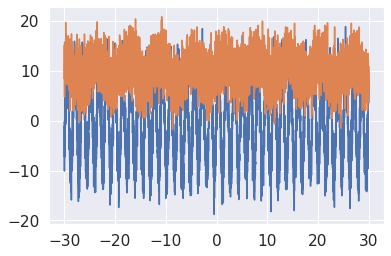

In [0]:
#Visualise distributions:
x = torch.arange(-30, 30, 0.01)

plt.plot(x, func0(x) )
plt.plot(x, func1(x) )
plt.show()

In [0]:
#Define dataset
train_x = torch.tensor(torch.zeros((1000, 100, 1)) )
train_y = []

#Sample from the two functions in one dataset
for i in range(1000):
    # sample class/function to use
    if np.random.randint(2) == 0:
        idx = np.random.randint(len(x) - 100)
        train_x[i] = func0(x[idx:idx+100]).reshape(100, 1)
        train_y.append(0)
        
    else:
        idx = np.random.randint(len(x) - 100)
        train_x[i] = func1(x[idx:idx+100]).reshape(100, 1)
        train_y.append(1)

train_y = torch.tensor(train_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [0]:
from torch.nn.functional import log_softmax, sigmoid
class rnn_network(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(rnn_network, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.rnn_layer1 = nn.RNN(self.embedding_dim, self.hidden_dim, batch_first=True, num_layers=1)
        self.output_layer = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):

        out, ct = self.rnn_layer1(x)
        out = out.contiguous().view(-1, self.hidden_dim)

        out = out.view(len(x), -1)

        out = out[:,-1]

        return out

In [0]:
#Initialize the neural network from PyTorch
torch_model = rnn_network(embedding_dim=1, hidden_dim=50) 

In [0]:
from pyro.distributions import Normal
def nnet_model(X, y=None):
  
    
    # Convert the PyTorch neural net into a Pyro model with priors
    # Priors for the neural model
    priors = {} 

    # Loop over all neural network parameters
    for name, par in torch_model.named_parameters():     
        
        # Each parameter has a N(0, 5) prior
        priors[name] = dist.Normal(torch.zeros(*par.shape), 5*torch.ones(*par.shape)).independent(1) 
    
    # Make this model and these priors a Pyro model
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors)

    # Initialize the model 
    sampled_model = bayesian_model()                                           
    
    # The generative process
    with pyro.plate("observations"):

        # Feed-forward the design matrix X through the neural network
        predicted_labels = sigmoid(sampled_model(X)) 
        y = pyro.sample("obs", dist.Bernoulli(probs=predicted_labels), obs=y)

    return y

In [0]:
softplus = torch.nn.Softplus()

def guide(x, y = None):

    # Layer rnn_ih_10
    rnn_ih_l0_mu = torch.randn_like(torch_model.rnn_layer1.weight_ih_l0)
    rnn_ih_l0_sigma = torch.randn_like(torch_model.rnn_layer1.weight_ih_l0)
    rnn_ih_l0_mu_param = pyro.param("rnn_ih_l0_mu", rnn_ih_l0_mu)
    rnn_ih_l0_sigma_param = softplus(pyro.param("rnn_ih_l0_sigma", rnn_ih_l0_sigma))
    rnn_ih_l0_prior = Normal(loc=rnn_ih_l0_mu_param, scale=rnn_ih_l0_sigma_param)
    
    #Layer rnn_hh_10
    rnn_hh_l0_mu = torch.randn_like(torch_model.rnn_layer1.weight_hh_l0)
    rnn_hh_l0_sigma = torch.randn_like(torch_model.rnn_layer1.weight_hh_l0)
    rnn_hh_l0_mu_param = pyro.param("rnn_hh_l0_mu", rnn_hh_l0_mu)
    rnn_hh_l0_sigma_param = softplus(pyro.param("rnn_hh_l0_sigma", rnn_hh_l0_sigma))
    rnn_hh_l0_prior = Normal(loc=rnn_hh_l0_mu_param, scale=rnn_hh_l0_sigma_param)

    # Bias bias_ih_l0
    bias_ih_l0_mu = torch.randn_like(torch_model.rnn_layer1.bias_ih_l0)
    bias_ih_l0_sigma = torch.randn_like(torch_model.rnn_layer1.bias_ih_l0)
    bias_ih_l0_mu_param = pyro.param("bias_ih_l0_mu", bias_ih_l0_mu)
    bias_ih_l0_sigma_param = softplus(pyro.param("bias_ih_l0_sigma", bias_ih_l0_sigma))
    bias_ih_l0_prior = Normal(loc=bias_ih_l0_mu_param, scale=bias_ih_l0_sigma_param)

    # Bias bias_hh_l0
    bias_hh_l0_mu = torch.randn_like(torch_model.rnn_layer1.bias_hh_l0)
    bias_hh_l0_sigma = torch.randn_like(torch_model.rnn_layer1.bias_hh_l0)
    bias_hh_l0_mu_param = pyro.param("bias_hh_l0_mu", bias_hh_l0_mu)
    bias_hh_l0_sigma_param = softplus(pyro.param("bias_hh_l0_sigma", bias_hh_l0_sigma))
    bias_hh_l0_prior = Normal(loc=bias_hh_l0_mu_param, scale=bias_hh_l0_sigma_param)

    # Output layer weight distribution priors
    outw_mu = torch.randn_like(torch_model.output_layer.weight)
    outw_sigma = torch.randn_like(torch_model.output_layer.weight)
    outw_mu_param = pyro.param("output_layer_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("output_layer_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param)

    # Output layer bias distribution priors
    outb_mu = torch.randn_like(torch_model.output_layer.bias)
    outb_sigma = torch.randn_like(torch_model.output_layer.bias)
    outb_mu_param = pyro.param("output_layer_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("output_layer_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)

    priors = {'rnn_layer1.weight_ih_l0': rnn_ih_l0_prior,
              'rnn_layer1.bias_ih_l0': bias_ih_l0_prior,
              'rnn_layer1.weight_hh_l0': rnn_hh_l0_prior,
              'rnn_layer1.bias_hh_l0': bias_hh_l0_prior,
              'output_layer.weight': outw_prior,
              'output_layer.bias': outb_prior}
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors)
    
    return bayesian_model()

In [0]:
#Pick whether to use predefined or custom guide:
#guide = AutoDelta(nnet_model)

In [0]:
# Define the number of optimization steps
n_steps = 50

pyro.clear_param_store()

loss_list = []

# Setup the optimizer
adam_params = {"lr": 0.1}
optimizer = Adam(adam_params)

# "Log" the ELBO scores:
elbo_list = list()

# Setup the inference algorithm
elbo = Trace_ELBO()
svi = SVI(nnet_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(train_x, train_y.type(torch.DoubleTensor))
    elbo_list.append(elbo)

    if step % 10 == 0:
        loss_list.append(elbo/len(train_x) )
        print("[%d] ELBO: %.1f" % (step, elbo))

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[0] ELBO: 7647.7
[10] ELBO: 7556.2
[20] ELBO: 7524.4
[30] ELBO: 7514.9
[40] ELBO: 7512.0
[50] ELBO: 7511.0


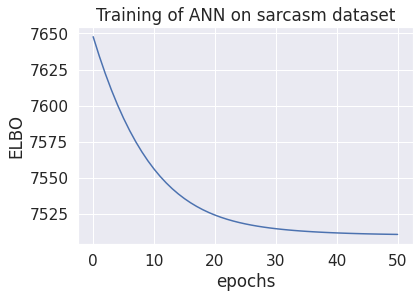

In [0]:
#Plot training ELBO
%matplotlib inline
plt.plot(elbo_list)
plt.title('Training of ANN on sarcasm dataset')
plt.xlabel('epochs')
plt.ylabel('ELBO')
plt.show()

In [0]:
from pyro.infer import Predictive

# Make predictions for test set
predictive = Predictive(nnet_model, guide=guide, num_samples=100,
                        return_sites=("obs", "_RETURN"))
samples = predictive(train_x)

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
true_count = 0
for idx, pred in enumerate(torch.median(samples["obs"],dim=0, keepdim=False, out=None)[0]):
    if pred > 0.5:
        pred = 1
    else:
        pred = 0
    # Pyro permutes the labels, i.e. sarcastic=0 
    # and non-sarcastic=1
    if pred == train_y[idx].item():
        true_count += 1
print(true_count/len(train_x))

0.256


Above we have shown the error rate(%) of the Bayesian RNN on simulated data. Converting it to accuracy: $$Accuracy=1-error rate = 1-0.256=0.744$$

This is now a POC that the Bayesian RNN model with custom guide is able to learn from data.


# Bayesian RNN on sarcasm dataset

In [0]:
from torch.nn.functional import log_softmax, sigmoid
class rnn_network(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(rnn_network, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.rnn_layer1 = nn.RNN(self.embedding_dim, self.hidden_dim, batch_first=True, num_layers=1)
        self.output_layer = nn.Linear(hidden_dim, 1)

        #self.sig = nn.Sigmoid()
    
    def forward(self, x):

        out, ct = self.rnn_layer1(x)
        out = out.contiguous().view(-1, self.hidden_dim)

        out = out.view(len(padded_headlines), -1)

        out = out[:,-1]

        return out

In [0]:
# Initialize the neural network from PyTorch
torch_model = rnn_network(embedding_dim=100, hidden_dim=50)

In [0]:
from pyro.distributions import Normal
def nnet_model(X, y=None):
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        
        priors[name] = dist.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).independent(1) # Each parameter has a N(0, 1) prior
        #priors[name] = centered_normal(*par.shape, *par.shape).independent(1) # Each parameter has a N(0, 1) prior
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model
    
    # The generative process
    with pyro.plate("observations"):
        predicted_labels = sigmoid(sampled_model(X)).squeeze(-1) # Feed-forward the design matrix X through the neural network
        y = pyro.sample("obs", dist.Bernoulli(probs=predicted_labels), obs=y)
        
    return y

In [0]:
#Try both with predifined and our own custom made guide:
softplus = torch.nn.Softplus()

def guide(x, y=None):

    # Layer rnn_ih_10
    rnn_ih_l0_mu = torch.randn_like(torch_model.rnn_layer1.weight_ih_l0)
    rnn_ih_l0_sigma = torch.randn_like(torch_model.rnn_layer1.weight_ih_l0)
    rnn_ih_l0_mu_param = pyro.param("rnn_ih_l0_mu", rnn_ih_l0_mu)
    rnn_ih_l0_sigma_param = softplus(pyro.param("rnn_ih_l0_sigma", rnn_ih_l0_sigma))
    rnn_ih_l0_prior = Normal(loc=rnn_ih_l0_mu_param, scale=rnn_ih_l0_sigma_param)
    
    #Layer rnn_hh_10
    rnn_hh_l0_mu = torch.randn_like(torch_model.rnn_layer1.weight_hh_l0)
    rnn_hh_l0_sigma = torch.randn_like(torch_model.rnn_layer1.weight_hh_l0)
    rnn_hh_l0_mu_param = pyro.param("rnn_hh_l0_mu", rnn_hh_l0_mu)
    rnn_hh_l0_sigma_param = softplus(pyro.param("rnn_hh_l0_sigma", rnn_hh_l0_sigma))
    rnn_hh_l0_prior = Normal(loc=rnn_hh_l0_mu_param, scale=rnn_hh_l0_sigma_param)

    # Bias bias_ih_l0
    bias_ih_l0_mu = torch.randn_like(torch_model.rnn_layer1.bias_ih_l0)
    bias_ih_l0_sigma = torch.randn_like(torch_model.rnn_layer1.bias_ih_l0)
    bias_ih_l0_mu_param = pyro.param("bias_ih_l0_mu", bias_ih_l0_mu)
    bias_ih_l0_sigma_param = softplus(pyro.param("bias_ih_l0_sigma", bias_ih_l0_sigma))
    bias_ih_l0_prior = Normal(loc=bias_ih_l0_mu_param, scale=bias_ih_l0_sigma_param)

    # Bias bias_hh_l0
    bias_hh_l0_mu = torch.randn_like(torch_model.rnn_layer1.bias_hh_l0)
    bias_hh_l0_sigma = torch.randn_like(torch_model.rnn_layer1.bias_hh_l0)
    bias_hh_l0_mu_param = pyro.param("bias_hh_l0_mu", bias_hh_l0_mu)
    bias_hh_l0_sigma_param = softplus(pyro.param("bias_hh_l0_sigma", bias_hh_l0_sigma))
    bias_hh_l0_prior = Normal(loc=bias_hh_l0_mu_param, scale=bias_hh_l0_sigma_param)

    # Output layer weight distribution priors
    outw_mu = torch.randn_like(torch_model.output_layer.weight)
    outw_sigma = torch.randn_like(torch_model.output_layer.weight)
    outw_mu_param = pyro.param("output_layer_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("output_layer_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param)

    # Output layer bias distribution priors
    outb_mu = torch.randn_like(torch_model.output_layer.bias)
    outb_sigma = torch.randn_like(torch_model.output_layer.bias)
    outb_mu_param = pyro.param("output_layer_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("output_layer_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)

    priors = {'rnn_layer1.weight_ih_l0': rnn_ih_l0_prior,
              'rnn_layer1.bias_ih_l0': bias_ih_l0_prior,
              'rnn_layer1.weight_hh_l0': rnn_hh_l0_prior,
              'rnn_layer1.bias_hh_l0': bias_hh_l0_prior,
              'output_layer.weight': outw_prior,
              'output_layer.bias': outb_prior}
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors)
    
    return bayesian_model()


In [0]:
#Pick whether to use custom or predifined guide:
#guide = AutoDelta(nnet_model)

In [0]:
# Define the number of optimization steps
n_steps = 100

#pyro.clear_param_store()

loss_list = []

# Setup the optimizer
adam_params = {"lr": 0.1}
optimizer = Adam(adam_params)

# "Log" the ELBO scores:
elbo_list = list()

# Setup the inference algorithm
elbo = Trace_ELBO()

svi = SVI(nnet_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(padded_headlines, torch.tensor(labels).type(torch.DoubleTensor))
    elbo_list.append(elbo)

    if step % 10 == 0:
        loss_list.append(elbo/len(padded_headlines) )
        print("[%d] ELBO: %.1f" % (step, elbo))

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[0] ELBO: 24498.8
[10] ELBO: 19733.2
[20] ELBO: 18351.4
[30] ELBO: 18091.5
[40] ELBO: 18001.9
[50] ELBO: 17988.5
[60] ELBO: 17956.5
[70] ELBO: 17922.2
[80] ELBO: 17916.2
[90] ELBO: 17902.4


Text(0, 0.5, 'ELBO')

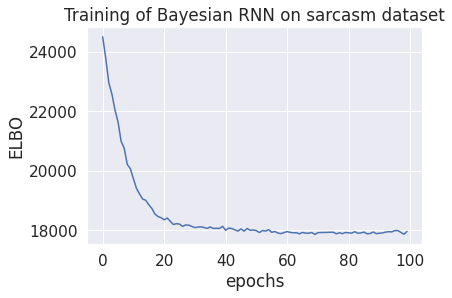

In [0]:
#Plot training ELBO
%matplotlib inline
plt.plot(elbo_list)
plt.title('Training of Bayesian RNN on sarcasm dataset')
plt.xlabel('epochs')
plt.ylabel('ELBO')

In [0]:
from pyro.infer import Predictive

# Make predictions for test set
predictive = Predictive(nnet_model, guide=guide, num_samples=20,
                        return_sites=("obs", "_RETURN"))
samples = predictive(padded_headlines)

true_count = 0
for idx, pred in enumerate(torch.median(samples["obs"],dim=0, keepdim=False, out=None)[0]):
    if pred > 0.5:
        pred = 1
    else:
        pred = 0
    if pred == labels[idx]:
        true_count += 1
print(true_count/len(padded_headlines))

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.523758697027198


# Pytorch LSTM network on sarcasm dataset

Since we now have 2 probabilisitic models that did not predict sarcasm very well, we now seek other types of models. In this case a LSTM network. 

In [0]:
class lstm_network(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(lstm_network, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.lstm_layer1 = nn.LSTM(self.embedding_dim, self.hidden_dim, batch_first=True, num_layers=1)
        self.output_layer = nn.Linear(hidden_dim, 1)

        self.sig = nn.Sigmoid()
    
    def forward(self, x):

        out, (ht, ct) = self.lstm_layer1(x)
        out = out.contiguous().view(-1, self.hidden_dim)

        out = out.view(len(padded_headlines), -1)

        out = out[:,-1]

        return out


In [0]:
lstm_net = lstm_network(100, 50)

In [0]:
epochs = 50
lr=0.01
labels = torch.tensor(labels).type(torch.DoubleTensor)


lstm_net.train()

optimizer = torch.optim.Adam(lstm_net.parameters(), lr=lr)
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
loss_list = []

for i in range(epochs):
    lstm_net.train()
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    output = lstm_net(padded_headlines)
    output = output.type(torch.DoubleTensor)
    #print(output)

    #loss = F.binary_cross_entropy(output.squeeze(), labels)
    loss = criterion(output.squeeze(), labels)
    print(loss.item())
    loss_list.append(loss.item())

    loss.backward()
    optimizer.step()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


0.6941677690756396
0.6900371604109314
0.6883910630210355
0.6880312874239732
0.6879107299167495
0.6876812500729069
0.6875144635399484
0.687283512239108
0.6869717410442976
0.6866623647757247
0.6864428188017734
0.6862854947177328
0.6860503534133306
0.685738650506672
0.6854901009163291
0.6852453051945627
0.6848706145079583
0.684501733469063
0.6841768081063814
0.6836862956975294
0.683234838397288
0.682752300401836
0.6821045588300294
0.6814861930554006
0.6807744933146648
0.6799053314890477
0.6790736693019065
0.6785347356323439
0.6777766297790225
0.6762673678637813
0.6754600330501005
0.6743848386275012
0.6728924461821606
0.6712331062018511
0.6696999657684617
0.6683266608192786
0.6707899528550518
0.668921782578977
0.6669861575241326
0.6663266558802993
0.6642130645811597
0.6619607565708108
0.6607281934245276
0.6613642977757231
0.658259319080735
0.6554603685363677
0.655678545443954
0.6523002224787356
0.6505766434271069
0.6504007805109782


Text(0, 0.5, 'BCE With LogLoss')

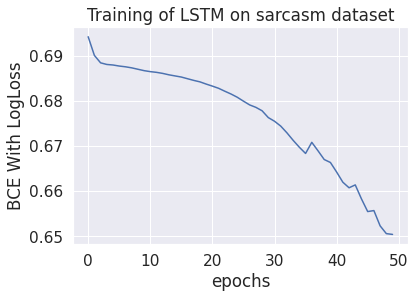

In [0]:
plt.plot(loss_list)
plt.title('Training of LSTM on sarcasm dataset')
plt.xlabel('epochs')
plt.ylabel('BCE With LogLoss')

In [0]:
true_count = 0
false_count = 0
preds = torch.sigmoid(lstm_net(padded_headlines))

for i in range(len(preds)):
    if preds[i] > 0.5:
        prediction = 1
    else:
        prediction = 0
    
    if prediction == labels[i]:
        true_count += 1
    else:
        false_count += 1


In [0]:
true_count / (true_count+false_count)

0.6797122074636306

# Non probabilistic Bayesline Model:

This baseline model is based of the idea presented in the article "Are Word Embedding-based Features Useful for Sarcasm Detection?" (a link to the article can be found in the top of the notebook).

 Essentially what this model does, is compare the words within each headline to each other to determine if it is sarcastic or not. It does this by computing the cosine similarity between all possible word pairs within a headline, and then extracting 4 values. These 4 valus are as follows: (i) the maximum similarity score for the most similar word in the sentence, (ii) the minimum similarity score for the most similar word in the sentence, (iii) the maximum similarity score for the least similar word in the sentence, and (iv) the minimum similarity score for the lease similar word in the sentence. Logistic regression is then run on these values to classify each headline to be either sarcastic or not.

The idea of this model was to reduce the dimensions of the problem from 100 dimensional vectors representing each word in a headline, to 4 values representing the entire headline. By doing this it reduces the complexity of the models inputs.

In [0]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import statistics as stat

In [0]:
def baseline_model(data=None, labels=None):

    """
    This baseline is based of the article - "Are Word Embedding-based 
    Features Useful for Sarcasm Detection?" 
    """
    #Predefining Matricies 
    Final_scores = np.zeros((4,np.shape(data)[0]))
    #Diff = np.zeros((3,np.shape(data)[0]))

    # Itterate through all headlines
    for n in range(np.shape(data)[0]):
    
        # Predefine similarity matrix to be (#words x #words) - resets to zero after every headline
        sim_matrix = np.zeros((len(data[n]),len(data[n])))
        
        # Itterate through each word in the headline and compare it to all other words in the headline
        for i in range(len(data[n])):
            for j in range(len(data[n])):
                
                # Calculate similarity score as cosinesimilarity in 100 dimensions
                cos_sim = "{:.2f}".format(np.dot(data[n][i], data[n][j])/(np.linalg.norm(data[n][i])*np.linalg.norm(data[n][j])))
                
                # Insert similarity score in the similarity matrix
                sim_matrix[i,j] = cos_sim
  
        # Compute the most and least similar word to the rest and return its row
        Max_sim_word = np.argmax(sim_matrix.sum(axis=0))
        Min_sim_word = np.argmin(sim_matrix.sum(axis=0))
            
        # Locate and extract the 4 values:
        # Maximum and minimum score of most similar word pair as well as the 
        # Maximum and minimum score of most dissimilar pair
        Max_sim_score = max(x for x in sim_matrix[:,Max_sim_word] if x < 1)
        Min_sim_score = min(sim_matrix[:,Max_sim_word])
        Max_disim_score = max(x for x in sim_matrix[:,Min_sim_word] if x < 1)
        Min_disim_score = min(sim_matrix[:,Min_sim_word])

        # Define scores which will be used to estimate sarcasm
        Scores = [Max_sim_score , Min_sim_score , Max_disim_score , Min_disim_score]
        #Diff[:,n] = [Scores[0] , Scores[2] ,Scores[0]-Scores[2] ]
        Final_scores[:,n] = Scores


## Logistic regression
    # Initialize variables
    lambdas = np.logspace(-2, 10, 14)
    N = len(lambdas)
    T = len(labels)
    j = 0

    # Initialize crossvalidation
    K = 10
    CV = model_selection.KFold(n_splits=K,shuffle=True)

    #Normalise Final_scores and transposes it to have the right dimensions
    Final_norm = (np.subtract(Final_scores, np.transpose(np.ones((len(labels),Final_scores.shape[0]))*np.mean(Final_scores,axis=1)/np.std(Final_scores,axis=1)))).T

    print(len(Final_norm))

    #Predefine error matrix
    Error = np.empty((K,N))

    #Predefine min_error and min_lambda vectors
    min_errors = np.empty(K)
    min_lambda = np.empty(K)

   
    #This splits the data into test and train indexes
    for train_index, test_index in CV.split(Final_norm):
        print('Computing CV fold: {0}/{1}..'.format(j+1,K))

        # Assigns the values of Final_norm to their test/train indexes
        X_train, y_train = Final_norm[train_index,:], labels[train_index]
        X_test, y_test = Final_norm[test_index,:], labels[test_index]
      
        # Predefining vectors
        train_error_rate = np.zeros(N)
        test_error_rate = np.zeros(N)
        
        # Run logistic regression on the test and train folds
        for k in range(0,N):
            mdl = LogisticRegression(penalty='l2', C=1/lambdas[k])
            
            mdl.fit(X_train, y_train)

            y_train_est = mdl.predict(X_train).T
            y_test_est = mdl.predict(X_test).T

            train_error_rate[k] = np.sum(y_train_est != y_train)/len(y_train)
            test_error_rate[k] = np.sum(y_test_est != y_test)/len(y_test)
        
        # Stores all the errors in error matrix
        Error[j,:] = test_error_rate
        
        # Stores min_error and its lambda for each split fold
        min_errors[j] = min(test_error_rate)
        min_lambda[j] = lambdas[np.argmin(test_error_rate)]
        j += 1

    print("Minimum error for each fold: {0}" , min_errors)
    print("Minimum lambda variable for each fold: {0}", min_lambda)

    plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.boxplot(Error)
    plt.xlabel('Regularization strength, $\log_{10}(\lambda)$')
    plt.ylabel('Error rate (%)')
    plt.title('Classification error')
    plt.show()


25296
Computing CV fold: 1/10..
Computing CV fold: 2/10..
Computing CV fold: 3/10..
Computing CV fold: 4/10..
Computing CV fold: 5/10..
Computing CV fold: 6/10..
Computing CV fold: 7/10..
Computing CV fold: 8/10..
Computing CV fold: 9/10..
Computing CV fold: 10/10..
Minimum error for each fold: {0} [0.45573123 0.44031621 0.43280632 0.45849802 0.44782609 0.46126482
 0.43851325 0.44128114 0.46263345 0.4551206 ]
Minimum lambda variable for each fold: {0} [4.12462638e+02 1.00000000e-02 4.12462638e+02 1.00000000e-02
 7.01703829e-01 4.12462638e+02 4.12462638e+02 4.92388263e+01
 4.92388263e+01 4.12462638e+02]


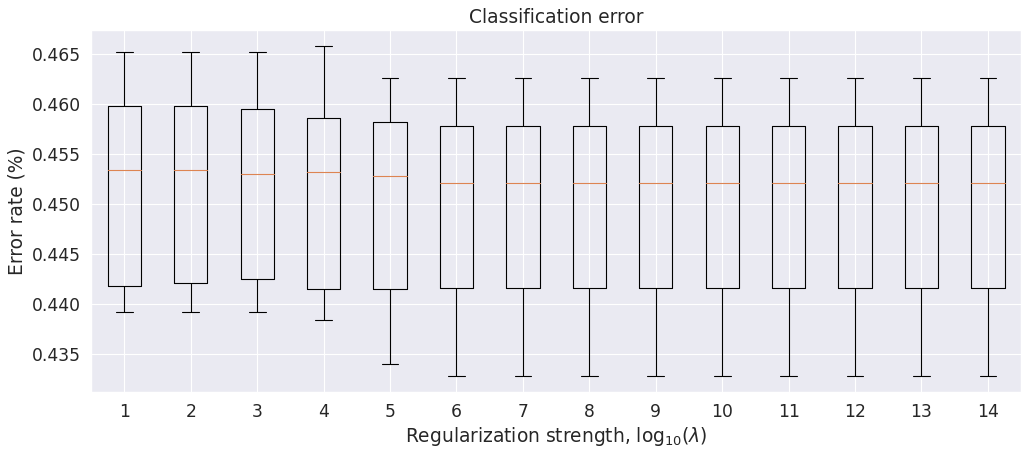

In [0]:
# Run the baseline model with parameters. Note that parameters must be 
# of type = numpy.array to work

final_list_base = [np.array(i) for i in final_list]
labels_base = [np.array(i) for i in labels]

baseline_model(np.array(final_list_base), np.array(labels_base))